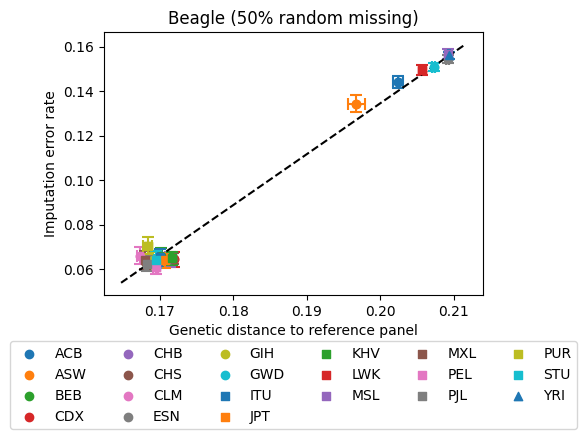

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, linregress   # 新增 linregress

# 1. 读入数据
df = pd.read_csv("/mnt/zqyin/Evofill/Fig1_b/Beagle/eval/per_individual_error_all_masks_with_distance.tsv",sep='\t')

def mean_ci95(series):
    n = series.count()
    mean = series.mean()
    sem = series.std(ddof=1) / n**0.5
    t_crit = t.ppf(0.975, df=n-1)
    return t_crit * sem

# 2. 分组统计（用于散点）
grp_stats = (df.groupby('Population')
               .agg(x_mean=('median_dist_to_EUR', 'mean'),
                    x_ci=('median_dist_to_EUR', mean_ci95),
                    y_mean=('ERROR_1_minus_ACC', 'mean'),
                    y_ci=('ERROR_1_minus_ACC', mean_ci95)))

# 3. 全场线性回归（用原始点，不是均值）
slope, inter, r_val, p_val, stderr = linregress(df['median_dist_to_EUR'],
                                                df['ERROR_1_minus_ACC'])

# 4. 画图
plt.figure(figsize=(5.5, 4))

# --- 颜色 + marker 池 ---
colors  = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd',
           '#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
markers = ['o','s','^','v','<','>','P','*','X','D']   # 10 个形状
n_color = len(colors)
n_marker = len(markers)


# 5. 画误差棒散点
for idx, pop in enumerate(grp_stats.index):
    row = grp_stats.loc[pop]
    c = colors[idx % n_color]                # 颜色独立循环
    m = markers[(idx // n_color) % n_marker] # 形状每 n_color 组推进一次
    # 4.1 误差棒——不生成图例条目
    plt.errorbar(row.x_mean, row.y_mean,
                 xerr=row.x_ci, yerr=row.y_ci,
                 fmt=m, color=c, capsize=4, capthick=1.5,
                 label=None)

    # 无误差散点——给 legend 用
    plt.scatter(row.x_mean, row.y_mean,
                marker=m, color=c, label=pop)

# 5. 加全场虚线拟合
x_fit = plt.xlim()                       # 当前轴范围
y_fit = [slope * x + inter for x in x_fit]
plt.plot(x_fit, y_fit, 'k--', lw=1.5,
         label=None)

# 6. 轴标签等
plt.xlabel('Genetic distance to reference panel')
plt.ylabel('Imputation error rate')
plt.title('Beagle (50% random missing)')

# 7. legend：图外正下方 + 多行横排
plt.legend(loc='upper center',
           bbox_to_anchor=(0.5, -0.15),
           ncol=6,
           frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

In [1]:
%%bash
kgp_vcf="/mnt/qmtang/EvoFill_data/20251211_chr22/data/major_pops_train.vcf.gz"
aadr_vcf="/mnt/qmtang/EvoFill_data/20251211_chr22/augment/hg38_chr22.AADRl_plus_Shimao.vcf.gz"

# 用 AC/AN 算 AF
bcftools query -f '%CHROM:%POS:%REF:%ALT\t%AC\t%AN\n' -i 'TYPE="snp"' "$kgp_vcf" | \
awk 'BEGIN{OFS="\t"} {if($3>0) print $1, $2/$3}' | sort > kgp.af.tsv

bcftools +fill-tags $aadr_vcf -- -t AF > aadr_with_af.vcf.gz
bcftools query -f '%CHROM:%POS:%REF:%ALT\t%AC\t%AN\n' -i 'TYPE="snp"' "aadr_with_af.vcf.gz" | \
awk 'BEGIN{OFS="\t"} {if($3>0) print $1, $2/$3}' | sort > aadr.af.tsv

# 合并并算差异
join -t $'\t' kgp.af.tsv aadr.af.tsv > common.af.tsv
awk 'BEGIN{OFS="\t"} {diff=$2-$3; print $1, $2, $3, diff}' common.af.tsv > af_diff.tsv


In [2]:
import pandas as pd
df = pd.read_csv('af_diff.tsv',sep='\t',header=None)
x = df.iloc[:,1].values
y = df.iloc[:,2].values

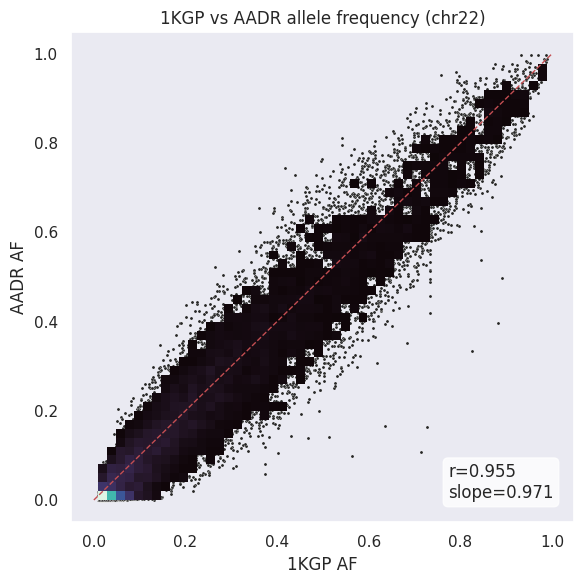

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")

f, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
# sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

# y=x 参考线
lim = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lim, lim, 'r--', lw=1)

# 统计指标
r = np.corrcoef(x, y)[0,1]
slope = np.polyfit(x, y, 1)[0]
plt.text(0.75, 0.05, f'r={r:.3f}\nslope={slope:.3f}',
         transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='w', alpha=0.8))

plt.xlabel('1KGP AF')
plt.ylabel('AADR AF')
plt.title('1KGP vs AADR allele frequency (chr22)')
plt.tight_layout()
# outpng = f"af_xy_chr{CHROM}.png"
# plt.savefig(outpng, dpi=300)
# print(f"Figure saved to {os.path.abspath(outpng)}")

In [ ]:
import os, random, itertools
import numpy as np
import matplotlib.pyplot as plt
from cyvcf2 import VCF

WIN_SIZE    = 50_000          # 50 kb 窗口
MIN_R2_PAIR = 10              # 窗口内至少有 10 对 SNP 才保留
SAMPLE_PAIRS= 50_000          # 用于 XY 散点的随机 SNP 对数
MAX_DIST    = 50_000          # 仅考虑 10–50 kb 距离（可改）

# -------------- 小工具 --------------
def allele_count(gt_types):
    """返回 (ref_count, alt_count)"""
    ok = gt_types < 3
    ref = (gt_types[ok] == 0).sum() * 2 + (gt_types[ok] == 1).sum()
    alt = (gt_types[ok] == 2).sum() * 2 + (gt_types[ok] == 1).sum()
    return ref, alt

def r2_two_snps(g1, g2):
    """输入两个 gt_types 数组，返回 r²"""
    ok = (g1 < 3) & (g2 < 3)
    if ok.sum() < 10:
        return np.nan
    # 编码 0/1/2
    x = g1[ok];  x = (x==1)*1 + (x==2)*2
    y = g2[ok];  y = (y==1)*1 + (y==2)*2
    # 快速 r²
    return np.corrcoef(x, y)[0,1]**2

# -------------- 1. 读 1KGP，建立 pos -> gt_types 映射 --------------
print("Loading 1KGP genotypes ...")
kgp = {}
for v in VCF(kgp_vcf):
    if v.CHROM != CHROM: continue
    kgp[v.POS] = v.gt_types.copy()
print(f"1KGP  {len(kgp)} sites loaded")

# -------------- 2. 读 AADR，只保留交集 --------------
print("Loading AADR genotypes ...")
aadr = {}
for v in VCF(aadr_vcf):
    if v.CHROM != CHROM: continue
    if v.POS not in kgp: continue
    aadr[v.POS] = v.gt_types.copy()
print(f"AADR  {len(aadr)} intersect sites")

shared_pos = sorted(aadr.keys())

# -------------- 3. 窗口 ⟨r²⟩ 比较 --------------
def window_r2(pos_list, gt_dict):
    """返回 list of (start, end, avg_r2)"""
    start, res = 0, []
    n = len(pos_list)
    while start < n:
        s_pos = pos_list[start]
        e_pos = s_pos + WIN_SIZE
        end   = start
        while end < n and pos_list[end] < e_pos:
            end += 1
        if end - start < 2:
            start = end
            continue
        # 计算窗口内所有 pair r²
        pairs = []
        for i,j in itertools.combinations(range(start, end), 2):
            d = pos_list[j] - pos_list[i]
            if 0 < d <= MAX_DIST:
                pairs.append(r2_two_snps(gt_dict[pos_list[i]],
                                         gt_dict[pos_list[j]]))
        if len(pairs) >= MIN_R2_PAIR:
            res.append((s_pos, e_pos, np.nanmean(pairs)))
        start = end
    return res

kgp_win  = window_r2(shared_pos, kgp)
aadr_win = window_r2(shared_pos, aadr)
print(f"Windows with enough pairs: 1KGP={len(kgp_win)}, AADR={len(aadr_win)}")

# 对齐窗口
common = {(s,e): (r1,r2) for (s,e,r1) in kgp_win for (s2,e2,r2) in aadr_win if s==s2 and e==e2}
win_s, win_e = zip(*common.keys())
r1 = np.array([v[0] for v in common.values()])
r2 = np.array([v[1] for v in common.values()])

# -------------- 4. 随机 SNP 对 r² XY 图 --------------
print("Sampling random SNP pairs for XY plot ...")
xy_x, xy_y = [], []
tries = 0
while len(xy_x) < SAMPLE_PAIRS and tries < SAMPLE_PAIRS*10:
    tries += 1
    i = random.randint(0, len(shared_pos)-2)
    j = random.randint(i+1, len(shared_pos)-1)
    d = shared_pos[j] - shared_pos[i]
    if not (0 < d <= MAX_DIST): continue
    r_kgp = r2_two_snps(kgp[shared_pos[i]], kgp[shared_pos[j]])
    r_aadr= r2_two_snps(aadr[shared_pos[i]], aadr[shared_pos[j]])
    if np.isnan(r_kgp) or np.isnan(r_aadr): continue
    xy_x.append(r_kgp);  xy_y.append(r_aadr)

print(f"Usable pairs for XY: {len(xy_x)}")


**窗口 Δ⟨r²⟩ 直方图**

峰值在 0 附近且对称 → LD 结构基本对齐；

峰值明显偏移或拖尾 → 存在系统差异，需要「LD-aware 重采样」或「人群匹配」。

**SNP-pair r² 散点**

r ≥ 0.9 且 slope ≈ 1 → 局部 LD 高度一致；

r < 0.8 或 slope < 0.9 → 模型在 1KGP 学到的 haplotype 特征在 1240K 不通用，验证集自然掉分。

Figure saved to /mnt/qmtang/EvoFill/notebook/ld_compare_chrchr22.png


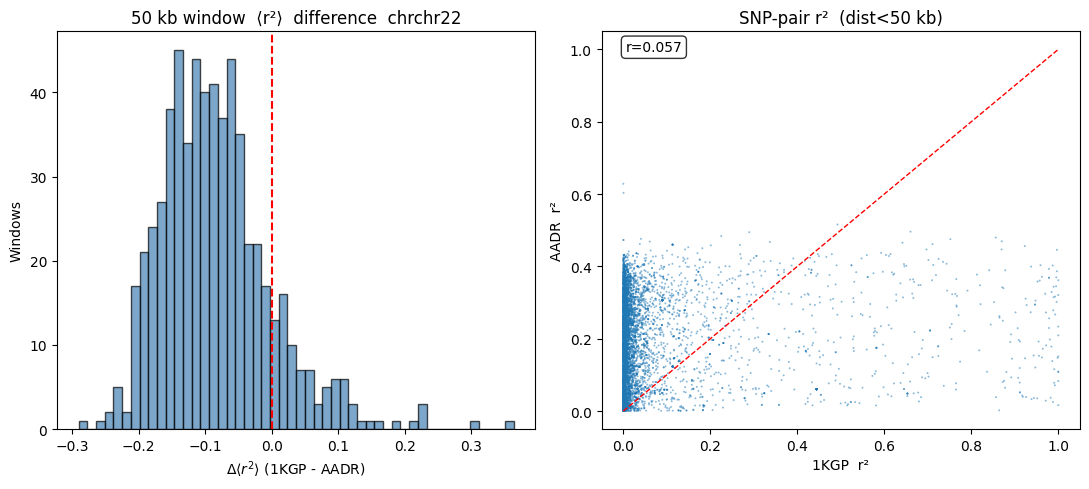

In [18]:
# -------------- 5. 画图 --------------
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11,5))

# 左：窗口 Δ⟨r²⟩
ax1.hist(r1-r2, bins=50, alpha=0.7, color='steelblue', edgecolor='k')
ax1.axvline(0, color='red', linestyle='--')
ax1.set_xlabel(r'$\Delta\langle r^2\rangle$ (1KGP - AADR)')
ax1.set_ylabel('Windows')
ax1.set_title(f'50 kb window  ⟨r²⟩  difference  chr{CHROM}')

# 右：r² 散点
# ax2.hexbin(xy_x, xy_y, gridsize=20, cmap='Blues', mincnt=1)
ax2.scatter(xy_x, xy_y, s=2, alpha=0.5, edgecolors='none')
lim = [0, 1]
ax2.plot(lim, lim, 'r--', lw=1)
r = np.corrcoef(xy_x, xy_y)[0,1]
ax2.text(0.05, 0.95, f'r={r:.3f}', transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='w', alpha=0.8))
ax2.set_xlabel('1KGP  r²')
ax2.set_ylabel('AADR  r²')
ax2.set_title(f'SNP-pair r²  (dist<{MAX_DIST//1000} kb)')

plt.tight_layout()
outpng = f"ld_compare_chr{CHROM}.png"
plt.savefig(outpng, dpi=300)
print(f"Figure saved to {os.path.abspath(outpng)}")

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
AADR -> 1KGP  分布对齐重采样
python resample_ld_af.py  > keep.samples.list
"""
import numpy as np
from cyvcf2 import VCF
import tqdm

# -------------- 路径 --------------
kgp_vcf  = "/mnt/qmtang/EvoFill_data/20251211_chr22/data/major_pops_train.vcf.gz"
aadr_vcf = "/mnt/qmtang/EvoFill_data/20251211_chr22/augment/hg38_chr22.AADRl_plus_Shimao.vcf.gz"
CHROM    = "chr22"
TOP_K    = 0.30          # 保留前 30 % 最相似个体

# -------------- 超参 --------------
WIN      = 50_000
MIN_PAIR = 10
MAX_DIST = 50_000
AF_BIN   = 0.02
LD_BIN   = 0.02

# -------------- 小工具 --------------
def allele_count(gt):
    """返回 (ref, alt) 计数"""
    ok = gt < 3
    ref = (gt[ok]==0).sum()*2 + (gt[ok]==1).sum()
    alt = (gt[ok]==2).sum()*2 + (gt[ok]==1).sum()
    return ref, alt

def r2_mean_in_win(pos_list, gt_mat, w_start, w_end):
    """gt_mat: (n_samp, n_snp)  0/1/2/-1"""
    idx = [i for i,p in enumerate(pos_list) if w_start <= p < w_end]
    if len(idx) < 2: return np.nan
    sub = gt_mat[:, idx]
    pairs = []
    for k in range(sub.shape[1]):
        for l in range(k+1, sub.shape[1]):
            d = pos_list[idx[l]] - pos_list[idx[k]]
            if 0 < d <= MAX_DIST:
                x = sub[:, k]; y = sub[:, l]
                ok = (x>=0) & (y>=0)
                if ok.sum() < 10: continue
                r = np.corrcoef(x[ok], y[ok])[0,1]**2
                pairs.append(r)
    return np.nanmean(pairs) if len(pairs)>=MIN_PAIR else np.nan

def hist_distance(p, q, binw):
    """交叉熵（AF）或 L2（LD）"""
    p = np.clip(p, 1e-6, 1-1e-6); q = np.clip(q, 1e-6, 1-1e-6)
    return np.sum(p * np.log(p/q))          # KL

# -------------- 1. 读 1KGP 基因型 --------------
print("Loading 1KGP ...")
kgp_pos, kgp_gt = [], []
for v in VCF(kgp_vcf):
    if v.CHROM != CHROM: continue
    kgp_pos.append(v.POS)
    kgp_gt.append(v.gt_types)
kgp_gt = np.array(kgp_gt).T          # shape=(n_ind, n_snp)
n_snp  = kgp_gt.shape[1]
print("1KGP n_ind={}, n_snp={}".format(kgp_gt.shape[0], n_snp))

# -------------- 2. 1KGP 目标分布 --------------
# 2.1 AF
target_af = np.array([allele_count(kgp_gt[:,i])[1]/(allele_count(kgp_gt[:,i])[0]+allele_count(kgp_gt[:,i])[1])
                      for i in range(n_snp)])
# 2.2 窗口 ⟨r²⟩
win_bins  = np.arange(0, max(kgp_pos)+WIN, WIN)
win_cent  = win_bins[:-1] + WIN//2
target_ld = np.array([r2_mean_in_win(kgp_pos, kgp_gt, s, s+WIN) for s in win_bins[:-1]])
print("1KGP  窗口数=", len(win_cent))


Loading 1KGP ...
1KGP n_ind=3009, n_snp=190184
1KGP  窗口数= 1017
Loading AADR ...


ValueError: 10519276 is not in list

In [21]:
# -------------- 3. 读 AADR 基因型 --------------
print("Loading AADR ...")
aadr_dict = {}                      # pos -> gt_types
for v in VCF(aadr_vcf):
    if v.CHROM != CHROM: 
        continue
    aadr_dict[v.POS] = v.gt_types   # 先放进 dict

# 与 1KGP 取交集，并按 1KGP 顺序拼矩阵
common_pos = [p for p in kgp_pos if p in aadr_dict]   # 保证必有
aadr_gt_list = [aadr_dict[p] for p in common_pos]     # 顺序同 kgp_pos
aadr_gt = np.array(aadr_gt_list, dtype=np.int8).T     # (n_ind_aadr, n_common)
print("AADR n_ind={}, n_snp(common)={}".format(aadr_gt.shape[0], aadr_gt.shape[1]))


Loading AADR ...
AADR n_ind=8953, n_snp(common)=14714


In [ ]:

# -------------- 4. 个体打分 --------------
n_common = aadr_gt.shape[1]          # 公共位点数
common_pos = np.array(common_pos)    # 与 aadr_gt 列顺序一致
n_aadr = aadr_gt.shape[0] 
scores = np.zeros(n_aadr)
for i in tqdm.trange(n_aadr):
    tmp_ref = np.delete(aadr_gt, i, axis=0)      # (n_aadr-1, n_common)
    
    # 1. AF 计算：只遍历公共位点
    tmp_af = np.empty(n_common)
    for j in range(n_common):
        ref, alt = allele_count(tmp_ref[:, j])
        tmp_af[j] = alt / (ref + alt + 1e-6)
    
    # 2. LD 计算：同样只传公共位点
    tmp_ld = np.array([r2_mean_in_win(common_pos, tmp_ref, s, s+WIN)
                       for s in win_bins[:-1]])
    
    # 3. 距离
    d_af = hist_distance(target_af[:n_common], tmp_af, AF_BIN)
    d_ld = np.nanmean((target_ld - tmp_ld)**2)
    scores[i] = d_af + 10*d_ld

# 分数越小越“多余”→ 反转
keep_n   = int(TOP_K * n_aadr)
keep_idx = np.argsort(scores)[:keep_n]          # 取最小（最相似）
print("保留个体数:", len(keep_idx))

# -------------- 5. 输出样本列表 --------------
with open("keep.samples.list","w") as f:
    for i in keep_idx:
        print(VCF(aadr_vcf).samples[i], file=f)
print("已写入 keep.samples.list")

Exception in initializer:
Traceback (most recent call last):
  File "/home/qmtang/miniconda3/envs/mamba/lib/python3.10/concurrent/futures/process.py", line 233, in _process_worker
    initializer(*initargs)
  File "/tmp/ipykernel_728538/3629929722.py", line 12, in _init_shm
    _gt         = np.ndarray(shape_gt, dtype=np.int8, buffer=_gt)
ValueError: operation forbidden on released memoryview object
Exception in initializer:
Traceback (most recent call last):
  File "/home/qmtang/miniconda3/envs/mamba/lib/python3.10/concurrent/futures/process.py", line 233, in _process_worker
    initializer(*initargs)
  File "/tmp/ipykernel_728538/3629929722.py", line 12, in _init_shm
    _gt         = np.ndarray(shape_gt, dtype=np.int8, buffer=_gt)
ValueError: operation forbidden on released memoryview object
Exception in initializer:
Traceback (most recent call last):
  File "/home/qmtang/miniconda3/envs/mamba/lib/python3.10/concurrent/futures/process.py", line 233, in _process_worker
    initialize

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

In [ ]:
!bcftools view -S keep.samples.list hg38_chr22.AADRl_plus_Shimao.vcf.gz -Oz -o AADR.ldAfMatched.vcf.gz